In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Dataset:
    def __init__(self, filename=None, X=None, Y=None):

        if filename is not None:
            self.readDataset(filename)
        elif X is not None and Y is not None:
            self.X = X
            self.Y = Y
    
    def readDataset(self, filename, sep = ","):
        data = np.genfromtxt(filename, delimiter=sep)
        self.X = data[:,0:-1]
        self.Y = data[:,-1]

    def getXy(self):
        return self.X, self.Y

def plotData_2vars(X, Y, xlabel, ylabel):
    plt.plot(X, Y, 'rx', markersize=7)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

def standardize(X):
    Xmed = np.mean(X, axis = 0)
    Xsigma = np.std(X, axis = 0)
    return (X-Xmed)/Xsigma
def normalize(X):
    Xmax = np.max(X, axis = 0)
    Xmin = np.min(X, axis = 0)
    return (X-Xmin)/(Xmax-Xmin)

def error_sqe(predictions,y):
    m = predictions.shape[0]
    #predictions = np.dot(self.X, self.theta)
    sqe = (predictions - y) ** 2
    res = np.sum(sqe) / (2*m)
    return res

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
def mapFeature (X1, X2, degrees = 6):
        out = np.ones( (np.shape(X1)[0], 1) )
        for i in range(1, degrees+1):
            for j in range(0, i+1):
                term1 = X1 ** (i-j)
                term2 = X2 ** (j)
                term = (term1 * term2).reshape( np.shape(term1)[0], 1 )
                out = np.hstack(( out, term ))
        return out

In [3]:
class LogisticRegression:
    def __init__(self, dataset, normalize = False, regularization = False, lamda = 1):
        self.X, self.y = dataset.getXy()
        self.X = np.hstack ( (np.ones([self.X.shape[0],1]), self.X ) )
        self.theta = np.zeros(self.X.shape[1])
        self.regularization = regularization
        self.lamda = lamda
        if normalize:
            self.normalize()
        else:
            self.normalized = False
    
    def normalize(self):
        self.mu = np.mean(self.X[:,1:], axis = 0)
        self.X[:,1:] = self.X[:,1:] - self.mu
        self.sigma = np.std(self.X[:,1:], axis = 0)
        if np.all(self.sigma!= 0): self.X[:,1:] = self.X[:,1:] / self.sigma
        self.normalized = True

    def printCoefs(self):
        print(self.theta)

    def predict (self, instance):
        p = self.probability(instance)
        if p >= 0.5: res = 1
        else: res = 0
        return res

    def probability(self, instance):
        x = np.empty([self.X.shape[1]])
        x[0] = 1
        x[1:] = np.array(instance[:self.X.shape[1]-1])
        # ...
        if self.normalized:
            if np.all(self.sigma!= 0):
                x[1:] = (x[1:] - self.mu) / self.sigma
            else: x[1:] = (x[1:] - self.mu)
        return sigmoid ( np.dot(self.theta, x))

    def costFunction(self, theta = None):
        if theta is None: theta= self.theta
        m = self.X.shape[0]
        ...
        p = sigmoid ( np.dot(self.X, theta) )
        cost = (-self.y * np.log(p) - (1-self.y) * np.log(1-p) )
        return cost

    def buildModel(self, dataset):
        if self.regularization:
            self.optim_model()
        else:
            self.optim_model_reg(self.lamda)

    def costFunctionReg(self, theta = None, lamda = 1):
        if theta is None: theta= self.theta
        m = self.X.shape[0]
        ...
        p = sigmoid ( np.dot(self.X, theta) )
        cost = (-self.y * np.log(p) - (1-self.y) * np.log(1-p) )
        reg = np.dot(theta[1:], theta[1:]) * lamda / (2*m)
        return (np.sum(cost) / m) + reg

    def gradientDescent(self, dataset, alpha = 0.01, iters = 10000):
        m = self.X.shape[0]
        n = self.X.shape[1]
        self.theta = np.zeros(n)
        for its in range(iters):
            J = self.costFunction()
            if its%1000 == 0: print(J)
            ...
            delta = self.X.T.dot(sigmoid(self.X.dot(self.theta)) - self.y)
            self.theta -= (alpha /m * delta )

    def optim_model(self):
        from scipy import optimize
        n = self.X.shape[1]
        options = {'full_output': True, 'maxiter': 500}
        initial_theta = np.zeros(n)
        self.theta, _, _, _, _ = optimize.fmin(lambda theta: self.costFunction(theta), initial_theta, **options)

    def optim_model_reg(self, lamda): #More sophisticated optimization methods
        from scipy import optimize
        n = self.X.shape[1]
        initial_theta = np.ones(n)
        result = optimize.minimize(lambda theta: self.costFunctionReg(theta, lamda), initial_theta, method='BFGS', options={"maxiter":500, "disp":False} )
        self.theta = result.x

    def mapX(self):
        self.origX = self.X.copy()
        mapX = mapFeature(self.X[:,1], self.X[:,2], 6)
        self.X = np.hstack((np.ones([self.X.shape[0],1]), mapX) )
        self.theta = np.zeros(self.X.shape[1])

    def plotData(self):
        negatives = self.X[self.y == 0]
        positives = self.X[self.y == 1]
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.xlim([self.X[:,1].min(), self.X[:,1].max()])
        plt.ylim([self.X[:,1].min(), self.X[:,1].max()])
        plt.scatter( negatives[:,1], negatives[:,2], c='r', marker='o', linewidths=1, s=40, label='y=0' )
        plt.scatter( positives[:,1], positives[:,2], c='k', marker='+', linewidths=2, s=40, label='y=1' )
        plt.legend()
        plt.show()

    def plotModel(self):
        from numpy import r_
        pos = (self.y == 1).nonzero()[:1]
        neg = (self.y == 0).nonzero()[:1]
        plt.plot(self.X[pos, 1].T, self.X[pos, 2].T, 'k+', markeredgewidth=2, markersize=7)
        plt.plot(self.X[neg, 1].T, self.X[neg, 2].T, 'ko', markerfacecolor='r', markersize=7)
        if self.X.shape[1] <= 3:
            plot_x = r_[self.X[:,2].min(), self.X[:,2].max()]
            plot_y = (-1./self.theta[2]) * (self.theta[1]*plot_x + self.theta[0])
            plt.plot(plot_x, plot_y)
            plt.legend(['class 1', 'class 0', 'Decision Boundary'])
        plt.show()

    def plotModel2(self):
        negatives = self.origX[self.y == 0]
        positives = self.origX[self.y == 1]
        plt.xlabel("x1"); plt.ylabel("x2")
        plt.xlim([self.origX[:,1].min(), self.origX[:,1].max()])
        plt.ylim([self.origX[:,1].min(), self.origX[:,1].max()])
        plt.scatter( negatives[:,1], negatives[:,2], c='r', marker='o', linewidths=1, s=40, label='y=0' )
        plt.scatter( positives[:,1], positives[:,2], c='k', marker='+', linewidths=2, s=40, label='y=1' )
        plt.legend()
        u = np.linspace( -1, 1.5, 50 )
        v = np.linspace( -1, 1.5, 50 )
        z = np.zeros( (len(u), len(v)) )
        for i in range(0, len(u)):
            for j in range(0, len(v)):
                x = np.empty([self.X.shape[1]])
                x[0] = 1
                mapped = mapFeature( np.array([u[i]]), np.array([v[j]]) )
                x[1:] = mapped
                z[i,j] = x.dot( self.theta )
            z = z.transpose()
            u, v = np.meshgrid( u, v )
            plt.contour( u, v, z, [0.0, 0.001])
            plt.show()

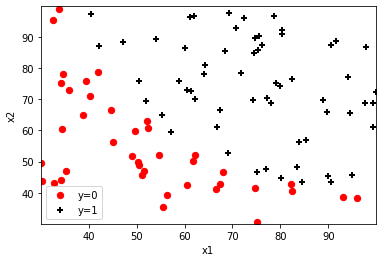

Initial cost:  [0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718 0.69314718
 0.69314718 0.69314718 0.69314718 0.69314718 0.

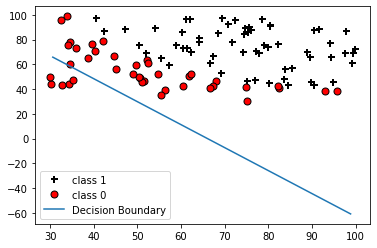

Final cost: [0.80142644 0.58235417 0.7850892  0.3744921  0.30252776 0.78826783
 0.33718005 0.4161634  0.28487508 0.36723592 1.29792517 0.97050932
 0.28336075 0.29063633 0.84327438 0.4035894  0.43379181 0.98984685
 0.29698772 0.39986647 0.95788991 0.27571315 0.80353531 0.6182448
 0.32631668 0.4171366  0.388931   1.2637385  0.9394942  0.77121322
 0.41287778 0.32063478 0.90685762 0.49151578 0.82214913 0.86854626
 0.91921855 0.36795711 1.04052344 0.78081245 0.33091046 0.80284594
 0.25471621 1.13139285 0.7915683  0.95572684 0.32594143 0.19714887
 0.33108343 0.21578395 0.30113259 0.24455983 0.33263683 0.70298438
 0.80635778 0.85780248 0.23378184 0.88345148 0.3441059  0.33187101
 0.29265876 0.64174235 0.80945134 0.60709616 0.84288932 0.93705504
 0.46528876 0.80534677 0.2541135  0.41948065 0.60073535 0.37816129
 0.28013135 0.41794016 0.41879118 0.21780211 0.45153264 0.4777283
 0.87523384 1.14446117 0.2692532  0.30340009 0.39614394 0.49264968
 0.25645718 0.32903401 0.88884434 0.28010816 0.25066

In [4]:
def test():
    ds = Dataset("log-ex1.data")
    logmodel = LogisticRegression(ds)
    logmodel.plotData()
    print ("Initial cost: ", logmodel.costFunction())
    logmodel.gradientDescent(ds, 0.001, 20000)
    logmodel.plotModel()
    print ("Final cost:", logmodel.costFunction())
    ex = np.array([45,65])
    print("Prob. example:", logmodel.probability(ex))
test()